https://www.kaggle.com/datasets/saldenisov/recipenlg

In [ ]:
!pip install python-igraph
!pip install networkx
#the following need to work restarting session
!pip install pycairo
!pip install cairocffi

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

data=pd.read_csv("dataset/full_dataset.csv")

In [25]:
data.head(5)

,Unnamed: 0,title,ingredients,directions,link,source,NER
0,0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""In a heavy 2-quart saucepan, mix brown sugar...",www.cookbooks.com/Recipe-Details.aspx?id=44874,Gathered,"[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""bu..."
1,1,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""Place chipped beef on bottom of baking dish....",www.cookbooks.com/Recipe-Details.aspx?id=699419,Gathered,"[""beef"", ""chicken breasts"", ""cream of mushroom..."
2,2,Creamy Corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""In a slow cooker, combine all ingredients. C...",www.cookbooks.com/Recipe-Details.aspx?id=10570,Gathered,"[""frozen corn"", ""cream cheese"", ""butter"", ""gar..."
3,3,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""Boil and debone chicken."", ""Put bite size pi...",www.cookbooks.com/Recipe-Details.aspx?id=897570,Gathered,"[""chicken"", ""chicken gravy"", ""cream of mushroo..."
4,4,Reeses Cups(Candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""Combine first four ingredients and press in ...",www.cookbooks.com/Recipe-Details.aspx?id=659239,Gathered,"[""peanut butter"", ""graham cracker crumbs"", ""bu..."


In [26]:
data=data[['title','NER']]
data

,title,NER
0,No-Bake Nut Cookies,"[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""bu..."
1,Jewell Ball'S Chicken,"[""beef"", ""chicken breasts"", ""cream of mushroom..."
2,Creamy Corn,"[""frozen corn"", ""cream cheese"", ""butter"", ""gar..."
3,Chicken Funny,"[""chicken"", ""chicken gravy"", ""cream of mushroo..."
4,Reeses Cups(Candy),"[""peanut butter"", ""graham cracker crumbs"", ""bu..."
...,...,...
2231137,Sunny's Fake Crepes,"[""chocolate hazelnut spread"", ""tortillas"", ""bu..."
2231138,Devil Eggs,"[""eggs"", ""paprika"", ""salt"", ""choice"", ""miracle..."
2231139,Extremely Easy and Quick - Namul Daikon Salad,"[""radish"", ""Sesame oil"", ""White sesame seeds"",..."
2231140,Pan-Roasted Pork Chops With Apple Fritters,"[""apple cider"", ""sugar"", ""kosher salt"", ""bay l..."


In [3]:
len(data)

2231142

In [27]:
from igraph import Graph, plot

import ast

def consruct_graph(sample):
    # Initialize graph
    g = Graph(directed=False)  # Create an undirected graph


    existing_vertices = set()

    for _, row in sample.iterrows():
        ingredients = ast.literal_eval(row['NER'])  # Convert string to list
        
        for i in range(len(ingredients)):
            for j in range(i + 1, len(ingredients)):
                #print(g.vs["name"])
                if ingredients[i] not in existing_vertices:# not g.vs["name"] as it's disabled after first intialize
                    g.add_vertex(name=ingredients[i])
                if ingredients[j] not in existing_vertices:
                    g.add_vertex(name=ingredients[j])
                
                if g.are_adjacent(ingredients[i], ingredients[j]):
                    edge_id=g.get_eid(ingredients[i],ingredients[j])
                    g.es[edge_id]["weight"]=g.es[edge_id]["weight"]+1
                else:
                    g.add_edge(ingredients[i], ingredients[j], weight=1)
        return g

**First**
- Construct graph of few recipes to could see how it look on small graphs

In [5]:
sample =data.sample(2,random_state=42)
g = consruct_graph(sample)

In [ ]:
for edge in g.es:
    source = g.vs[edge.source]["name"]
    target = g.vs[edge.target]["name"]
    weight = edge["weight"]
    print(f"{source} -- {target}: {weight}")


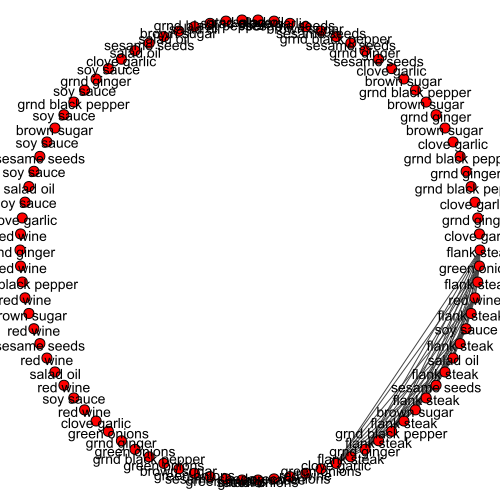

In [23]:
layout = g.layout("circle")  # Layout type: "circle", "fr", "kk", etc.
plot(
    g,
    layout=layout,
    vertex_label=list(((g.vs['name']))),  # Label nodes with their indices
    vertex_size = 10,
    edge_arrow_size = 0.5,
    bbox=(500, 500),  # Size of the visualization
    margin=20,
)


The plot look very complex even in small data ,let's try visualize using networkx library

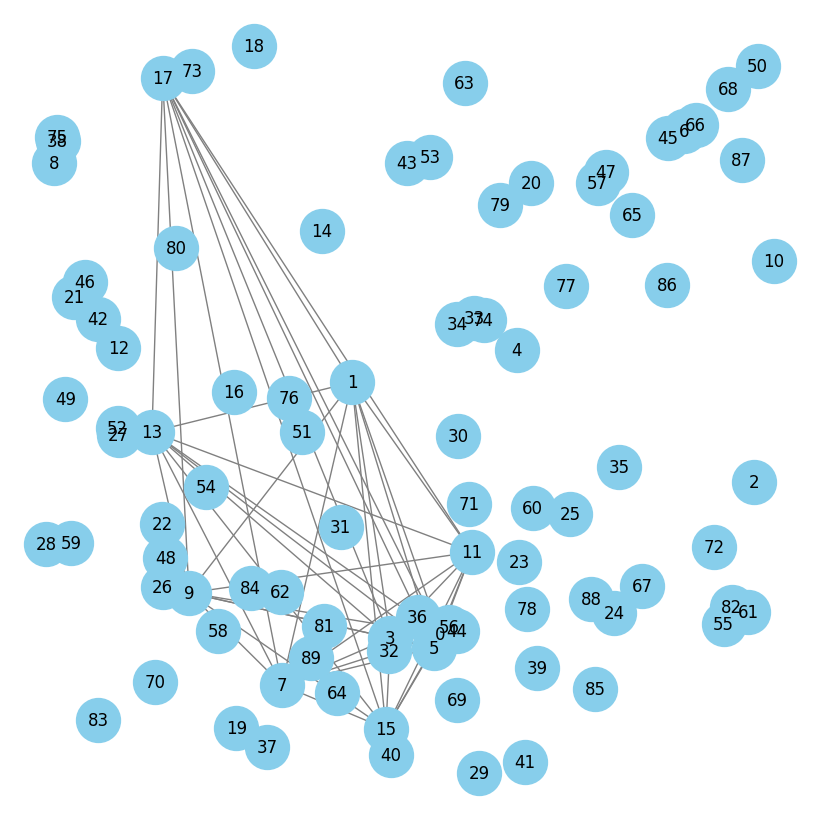

In [6]:
import networkx as nx
nx_graph = nx.Graph(g.get_edgelist())
nx_graph.add_nodes_from(range(g.vcount()))

# Plot using networkx
plt.figure(figsize=(8, 8))
nx.draw_random(nx_graph, with_labels=True, node_color='skyblue', font_size=12, node_size=1000, edge_color='gray')
plt.show()


Let's try other way of plotting ,may make it easier to understand

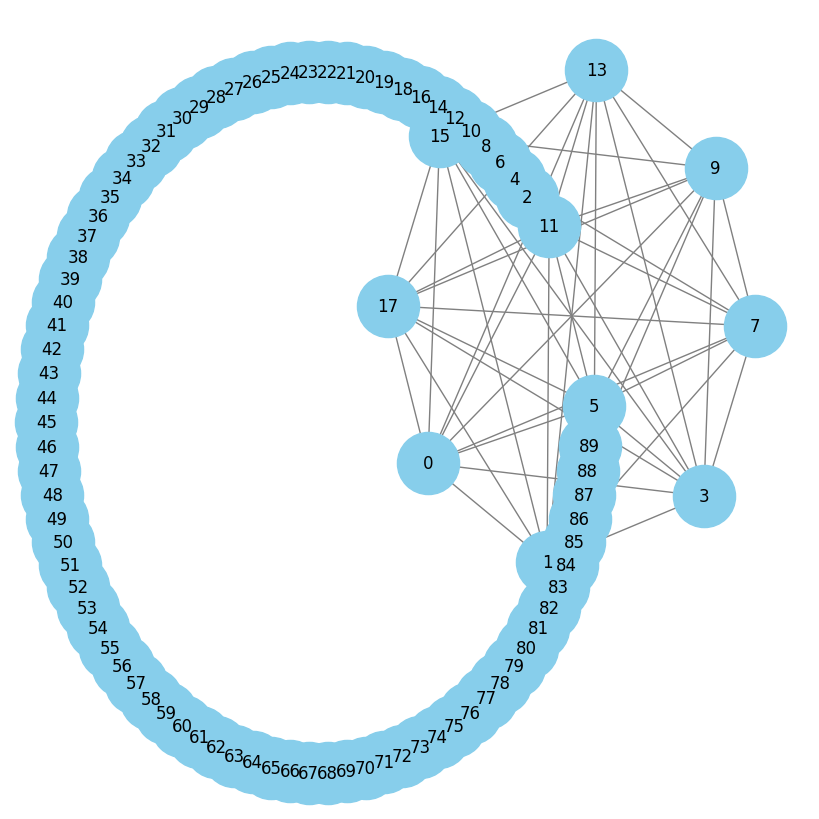

In [30]:
import networkx as nx
nx_graph = nx.Graph(g.get_edgelist())
nx_graph.add_nodes_from(range(g.vcount()))

# Plot using networkx
plt.figure(figsize=(8, 8))
nx.draw_kamada_kawai(nx_graph, with_labels=True, node_color='skyblue', font_size=12, node_size=2000, edge_color='gray')
plt.show()


- This mean that some ingredients are complete (mostly used themselve in any reciepe) ,other like isolated ,may on one or two reciepes
- Note : that nodes are became numbers (when converting to edge list) ,which is easier to visualize ,but harder to interpret ,the next functions get ingredient name from index

In [31]:
def get_index_Name(g):
    index_node= {"index":[],"Name":[]}

    for vertex in g.vs:
        index_node["index"].append(vertex.index)
        index_node["Name"].append(vertex['name'])

    return pd.DataFrame(index_node)


def loc_index(index_node,index):
    return index_node[index_node["index"]==index]

loc_index(get_index_Name(g),25)

,index,Name
25,25,sesame seeds


Now Let's try to visualize larger sample

In [72]:
sample =data.sample(30,random_state=42)
g = consruct_graph(sample)

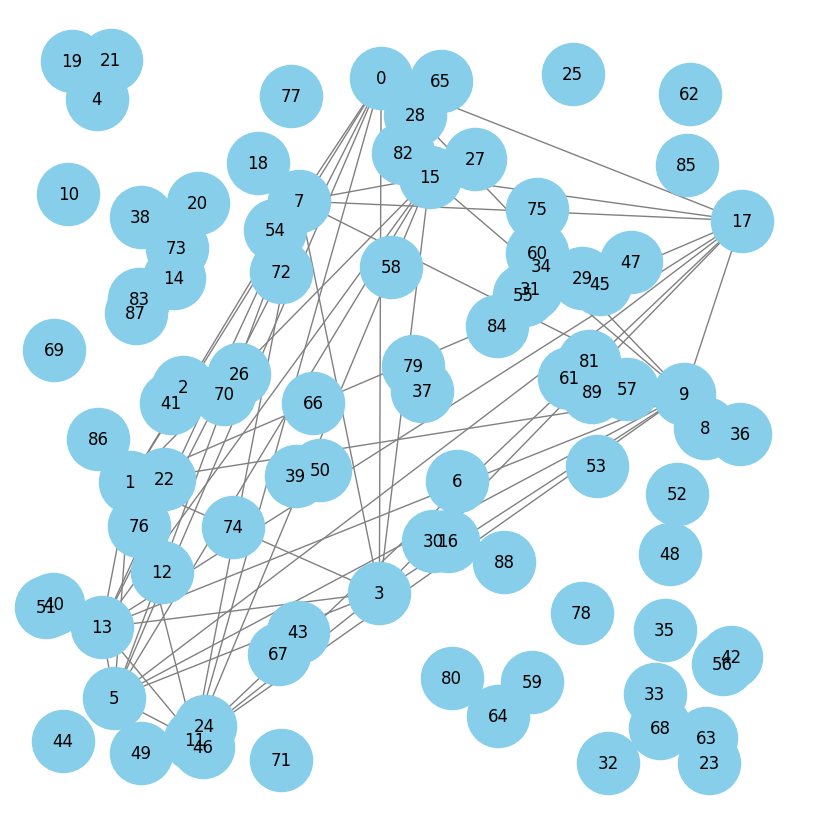

In [10]:
import networkx as nx
nx_graph = nx.Graph(g.get_edgelist())
nx_graph.add_nodes_from(range(g.vcount()))

# Plot using networkx
plt.figure(figsize=(8, 8))
nx.draw_random(nx_graph, with_labels=True, node_color='skyblue', font_size=12, node_size=2000, edge_color='gray')
plt.show()


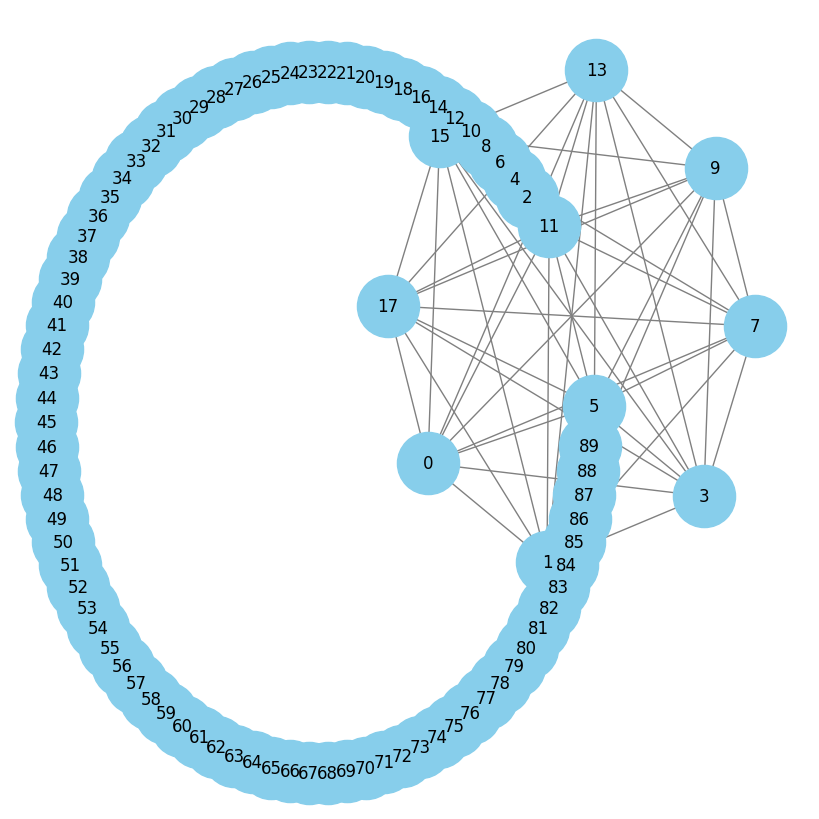

In [64]:
# Plot using networkx
plt.figure(figsize=(8, 8))
nx.draw_kamada_kawai(nx_graph, with_labels=True, node_color='skyblue', font_size=12, node_size=2000, edge_color='gray')
plt.show()


Same, Let's try discover patterns from large subset , try  representing into matrix and use measurements (the data is so large ,slow to load so we will still use sample)

In [11]:
sample = data.sample(500,random_state=42)
g = consruct_graph(sample)

In [32]:
degrees = g.degree()

# Map nodes to degrees in a DataFrame
node_degree_df = pd.DataFrame({
    'Node': range(len(g.vs)),    
    'Degree': degrees
})
node_degree_df

,Node,Degree
0,0,9
1,1,9
2,2,0
3,3,9
4,4,0
...,...,...
85,85,0
86,86,0
87,87,0
88,88,0


In [33]:
avg_degree=node_degree_df['Degree'].mean()
print(avg_degree)

1.0


meanly each individual NER used in one reciepe

In [34]:
# Edge List Representation
print("Edge List:")
print(g.get_edgelist())

Edge List:
[(0, 1), (0, 3), (0, 5), (0, 7), (0, 9), (0, 11), (0, 13), (0, 15), (0, 17), (1, 3), (1, 5), (1, 7), (1, 9), (1, 11), (1, 13), (1, 15), (1, 17), (3, 5), (3, 7), (3, 9), (3, 11), (3, 13), (3, 15), (3, 17), (5, 7), (5, 9), (5, 11), (5, 13), (5, 15), (5, 17), (7, 9), (7, 11), (7, 13), (7, 15), (7, 17), (9, 11), (9, 13), (9, 15), (9, 17), (11, 13), (11, 15), (11, 17), (13, 15), (13, 17), (15, 17)]


In [16]:
#Adjacent List Representation
print("\nAdjacent List (Dictionary):")
adjacent_list = {}
for source, target in g.get_edgelist():
  if source not in adjacent_list:
    adjacent_list[source] = []
  adjacent_list[source].append(target)
print(adjacent_list)


Adjacent List (Dictionary):
{0: [1, 3, 5, 7, 9, 11, 13, 15, 17], 1: [3, 5, 7, 9, 11, 13, 15, 17], 3: [5, 7, 9, 11, 13, 15, 17], 5: [7, 9, 11, 13, 15, 17], 7: [9, 11, 13, 15, 17], 9: [11, 13, 15, 17], 11: [13, 15, 17], 13: [15, 17], 15: [17]}


In [17]:
g.get_adjacency()

Matrix([[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [35]:
def is_special_graph(g):
    # (Complete Graph)
    if g.is_connected() and g.ecount() == (g.vcount() * (g.vcount() - 1)) // 2:
        return "Complete Graph"
    # (Cycle Graph)
    if g.is_connected() and g.ecount() == g.vcount() and all(g.degree() == [2] * g.vcount()):
        return "Cycle Graph"
    # (Tree)
    if g.is_connected() and g.ecount() == g.vcount() - 1:
        return "Tree"
    #  (Bipartite Graph)
    if g.is_bipartite():
        return "Bipartite Graph"
    #  if not(Complete Graph,Cycle Graph,Tree,Bipartite Graph)
    return "none"

In [36]:
is_special_graph(g)

'none'

The sample not strictly special type , this is logical and expected for the real food data ,let's try to check if it's close to special type

In [37]:
# Determine the closest type of the graph
def closest_graph_type(g):
    # Check if the graph is complete
    if g.ecount() == (g.vcount() * (g.vcount() - 1)) // 2:
        return "Complete Graph"
    
    # Check if the graph is a cycle
    if g.is_connected() and g.ecount() == g.vcount() and all(degree == 2 for degree in g.degree()):
        return "Cycle Graph"
    
    # Check if the graph is a tree
    if g.ecount() == g.vcount() - 1 and g.is_connected():
        return "Tree"
    
    # Check if the graph is bipartite
    if g.is_bipartite():
        return "Bipartite Graph"
    
    # If not a special graph, determine the closest resemblance
    if not g.is_connected():
        return "Disconnected Graph (No clear resemblance)"
    
    expected_edges = (g.vcount() * (g.vcount() - 1)) // 2
    if g.ecount() >= 0.8 * expected_edges:
        return "Almost Complete Graph"
    
    if all(degree in [2, 3] for degree in g.degree()):
        return "Almost Cycle Graph"
    
    if g.ecount() <= g.vcount():
        return "Tree-Like Graph"
    
    return "No clear resemblance"

# Analyze the graph
def analyze_graph_type(g):
    graph_type = closest_graph_type(g)
    print(f"The graph resembles: {graph_type}")




In [22]:
analyze_graph_type(g)

The graph resembles: Disconnected Graph (No clear resemblance)


This mean it's not close to some graph ,may be disconnected 

Now Let's check connectivity in details

In [39]:
def analyze_connectivity(g):
    # Vertex connectivity
    vertex_conn = g.vertex_connectivity()
    print(f"Vertex Connectivity: {vertex_conn}")

    # Edge connectivity
    edge_conn = g.edge_connectivity()
    print(f"Edge Connectivity: {edge_conn}")

    # Connected components
    components = g.connected_components()  # Updated to avoid deprecation warning
    print(f"Number of Connected Components: {len(components)}")
    for i, comp in enumerate(components):
        print(f"Component {i + 1}: {comp}")

    # Check if the graph is fully connected
    if g.is_connected():
        print("The graph is fully connected.")
    else:
        print("The graph is not fully connected.")



# Analyze connectivity
analyze_connectivity(g)


Vertex Connectivity: 0
Edge Connectivity: 0
Number of Connected Components: 81
Component 1: [0, 1, 3, 5, 7, 9, 11, 13, 15, 17]
Component 2: [2]
Component 3: [4]
Component 4: [6]
Component 5: [8]
Component 6: [10]
Component 7: [12]
Component 8: [14]
Component 9: [16]
Component 10: [18]
Component 11: [19]
Component 12: [20]
Component 13: [21]
Component 14: [22]
Component 15: [23]
Component 16: [24]
Component 17: [25]
Component 18: [26]
Component 19: [27]
Component 20: [28]
Component 21: [29]
Component 22: [30]
Component 23: [31]
Component 24: [32]
Component 25: [33]
Component 26: [34]
Component 27: [35]
Component 28: [36]
Component 29: [37]
Component 30: [38]
Component 31: [39]
Component 32: [40]
Component 33: [41]
Component 34: [42]
Component 35: [43]
Component 36: [44]
Component 37: [45]
Component 38: [46]
Component 39: [47]
Component 40: [48]
Component 41: [49]
Component 42: [50]
Component 43: [51]
Component 44: [52]
Component 45: [53]
Component 46: [54]
Component 47: [55]
Component 4

C:\Users\LapStore\AppData\Local\Temp\ipykernel_27772\3178350193.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('tab20', len(components)),


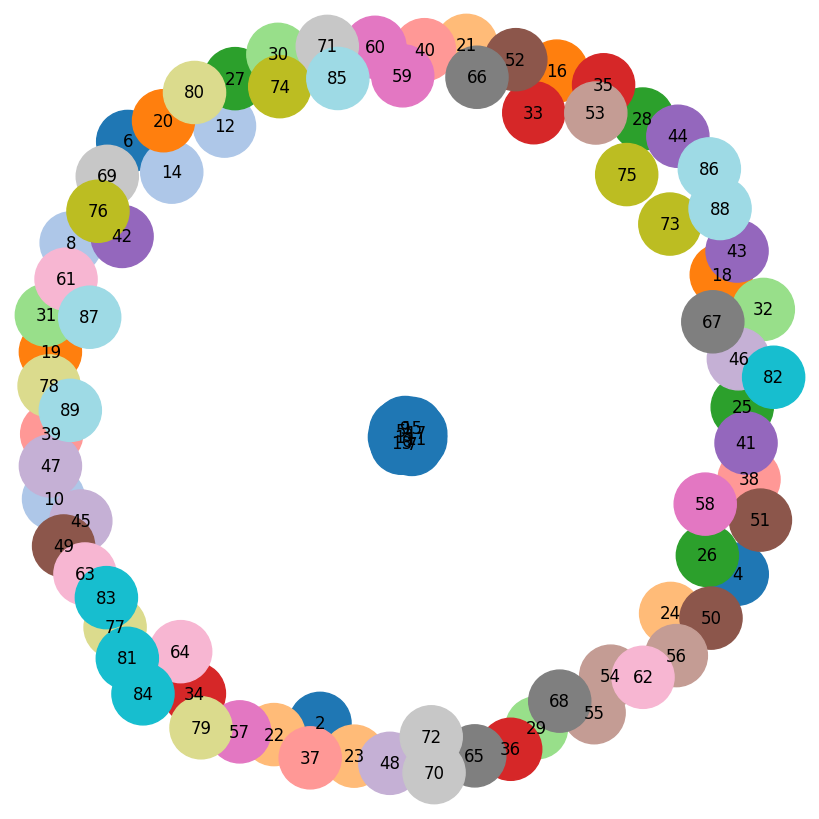

In [75]:
import networkx as nx
import matplotlib.pyplot as plt

# Convert igraph to networkx
nx_graph = nx.Graph(g.get_edgelist())
nx_graph.add_nodes_from(range(g.vcount()))

# Find connected components
components = list(nx.connected_components(nx_graph))

# Assign a unique color to each component
color_map = {}
for i, component in enumerate(components):
    for node in component:
        color_map[node] = i

# Generate a list of colors for each node based on its component
colors = [color_map[node] for node in nx_graph.nodes()]

# Draw the graph with distinct colors for each connected component
plt.figure(figsize=(8, 8))
nx.draw(nx_graph,
        with_labels=True,
        node_color=colors,
        cmap=plt.cm.get_cmap('tab20', len(components)),
        node_size=2000,
        edge_color='gray',
        font_size=12)
plt.show()


C:\Users\LapStore\AppData\Local\Temp\ipykernel_27772\2602079788.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('tab20', len(components)),


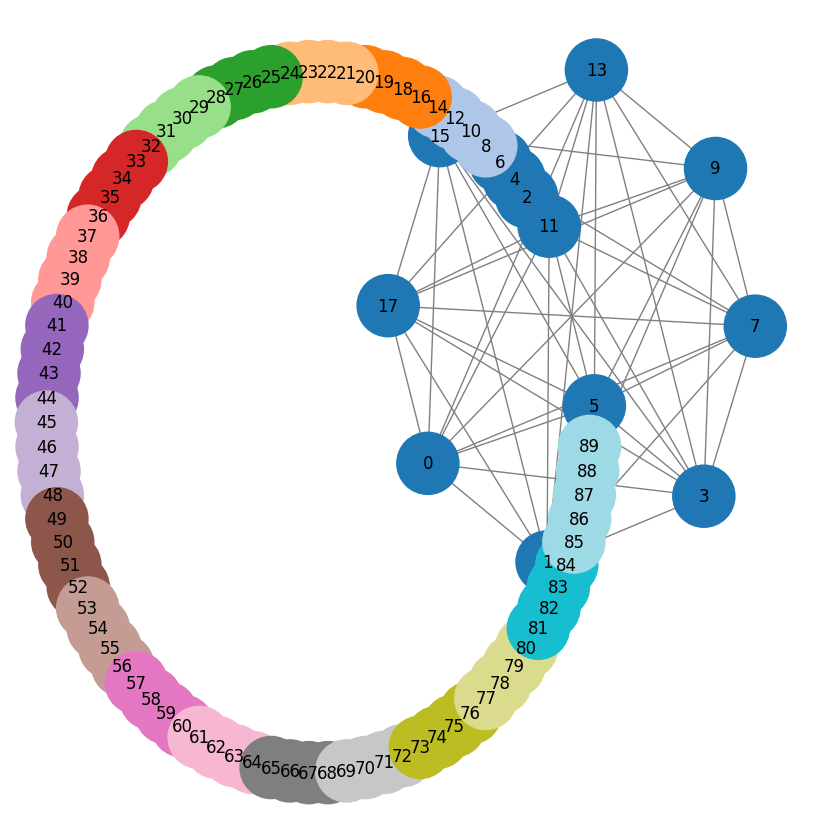

In [133]:
import networkx as nx
import matplotlib.pyplot as plt

# Convert igraph to networkx
nx_graph = nx.Graph(g.get_edgelist())
nx_graph.add_nodes_from(range(g.vcount()))

# Find connected components
components = list(nx.connected_components(nx_graph))

# Assign a unique color to each component
color_map = {}
for i, component in enumerate(components):
    for node in component:
        color_map[node] = i

# Generate a list of colors for each node based on its component
colors = [color_map[node] for node in nx_graph.nodes()]

# Draw the graph with distinct colors for each connected component
plt.figure(figsize=(8, 8))
nx.draw_kamada_kawai(nx_graph,
        with_labels=True,
        node_color=colors,
        cmap=plt.cm.get_cmap('tab20', len(components)),
        node_size=2000,
        edge_color='gray',
        font_size=12)
plt.show()


- This mean that some ingredients are complete (mostly used themselve in any reciepe) ,other like isolated ,may on one or two reciepes


Same result nearly from ploting , This mean that some ingredients are complete (mostly used themselve in any reciepe) ,other like isolated ,may on one or two reciepes


____________
Now Let's Explore which ingredinet is common and important?

In [ ]:
[0 if i is None else i for i in g.betweenness()]


In [40]:
import math
degree_centrality = g.degree()

# the list comprehension ensure it don't have nan ,replacing by 0
betweenness_centrality = [0 if i is None or (isinstance(i, float) and math.isnan(i)) else i for i in g.betweenness()]

closeness_centrality = [0 if i is None or (isinstance(i, float) and math.isnan(i)) else i for i in g.closeness()]

eigenvector_centrality = g.eigenvector_centrality()

#pagerank_centrality = g.pagerank()

centrelaity_data_frame =  pd.DataFrame(dict({"Node":range(len(degree_centrality)),
                                            "degree_centrality" : degree_centrality,
                                            "betweenness_centrality" :betweenness_centrality,
                                            "closeness_centrality" :closeness_centrality,
                                            "eigenvector_centrality" : eigenvector_centrality}))

centrelaity_data_frame 

,Node,degree_centrality,betweenness_centrality,closeness_centrality,eigenvector_centrality
0,0,9,0.0,1.0,1.0
1,1,9,0.0,1.0,1.0
2,2,0,0.0,0.0,0.0
3,3,9,0.0,1.0,1.0
4,4,0,0.0,0.0,0.0
...,...,...,...,...,...
85,85,0,0.0,0.0,0.0
86,86,0,0.0,0.0,0.0
87,87,0,0.0,0.0,0.0
88,88,0,0.0,0.0,0.0


Drawing histogram for better seeing centralities:


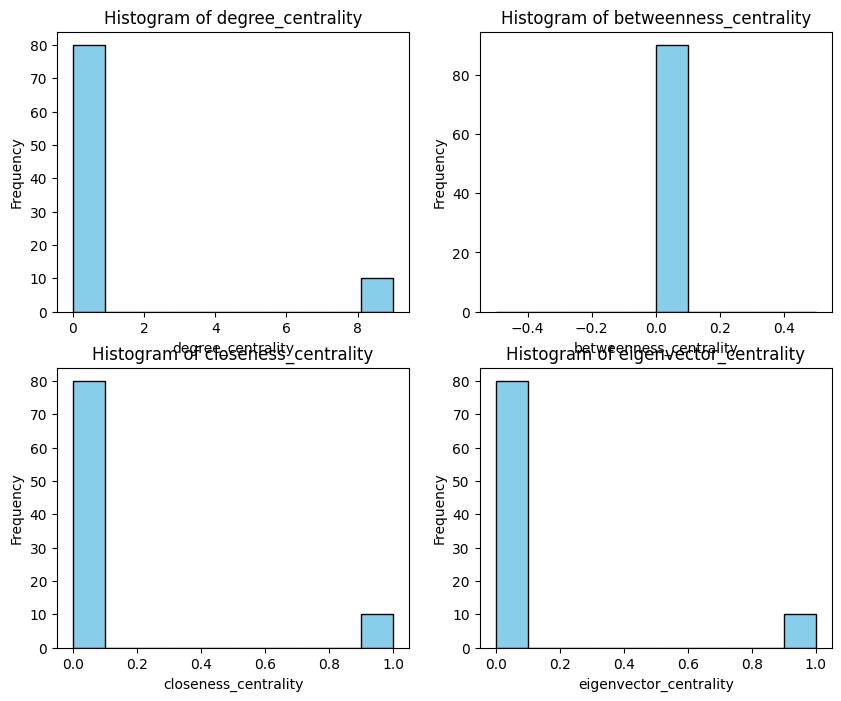

In [98]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8)) 
axes = axes.flatten()  

# Plot each column in a separate subplot
for i, column in enumerate(centrelaity_data_frame.columns[1:]):
    axes[i].hist(centrelaity_data_frame[column], color='skyblue', edgecolor='black')
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

In [36]:
len(g.vs)

90

The most important relating of centrality of our dataset is Degree centrality (what is main important ingredients i should have in restaurant as appera in many reciepes can be many so no need eignvalue)  

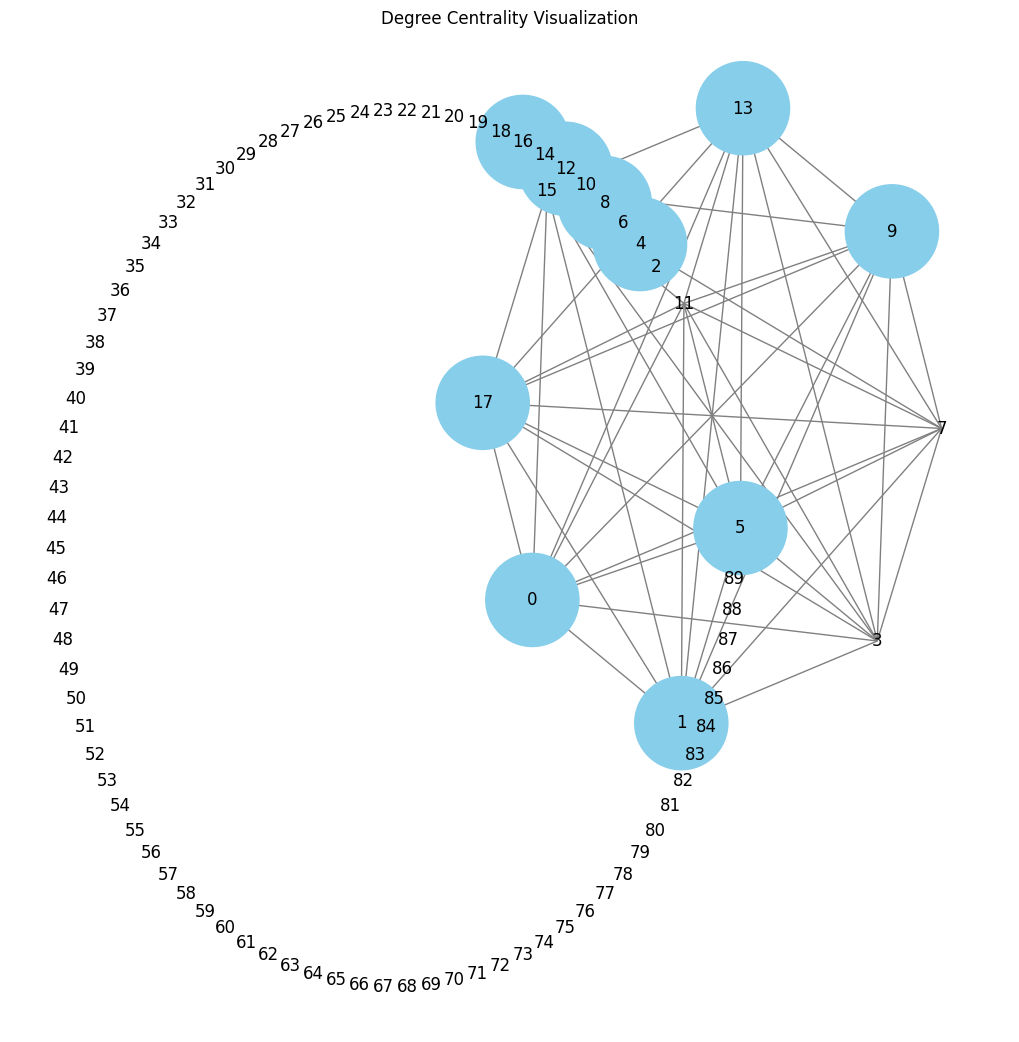

In [89]:
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(nx_graph)

#nx.draw_kamada_kawai(nx_graph, with_labels=True, node_color='skyblue', font_size=12, node_size=2000, edge_color='gray')

nx.draw_kamada_kawai(
    nx_graph,
    with_labels=True,
    node_color='skyblue',
    node_size= [500 * value for value in degree_centrality],
    font_size=12,
    edge_color='gray'
)

#labels = {node: f"{degree_centrality[node]:.2f}" for node in nx_graph.nodes()}
#nx.draw_networkx_labels(nx_graph, pos, labels=labels, font_size=10)

plt.title("Degree Centrality Visualization")
plt.show()


In [41]:
# Find the maximum value in the 'degree_centrality' column
max_value = centrelaity_data_frame['degree_centrality'].max()

rows_with_max_centrality = centrelaity_data_frame[centrelaity_data_frame['degree_centrality'] == max_value]
rows_with_max_centrality['name of node']=[ str(loc_index(get_index_Name(g),i)['Name'].iloc[0]) for i in rows_with_max_centrality['Node']]
rows_with_max_centrality[['Node','name of node','degree_centrality']]

C:\Users\LapStore\AppData\Local\Temp\ipykernel_4732\1745681136.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rows_with_max_centrality['name of node']=[ str(loc_index(get_index_Name(g),i)['Name'].iloc[0]) for i in rows_with_max_centrality['Node']]


,Node,name of node,degree_centrality
0,0,flank steak,9
1,1,green onions,9
3,3,red wine,9
5,5,soy sauce,9
7,7,salad oil,9
9,9,sesame seeds,9
11,11,brown sugar,9
13,13,grnd black pepper,9
15,15,grnd ginger,9
17,17,clove garlic,9
